In [18]:
import numpy as np
import matplotlib.pyplot as plt

# optional
from scipy import signal, stats

import mne

In [19]:
raw = mne.io.read_raw_fif("/pscratch/sd/t/tylee/SOLID_EEG_RESULT/synthetic_eeg/synthesis_251223_task/seizure_focal_frontal_raw.fif", preload=True)

Opening raw data file /pscratch/sd/t/tylee/SOLID_EEG_RESULT/synthetic_eeg/synthesis_251223_task/seizure_focal_frontal_raw.fif...
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Reading 0 ... 14999  =      0.000 ...    59.996 secs...


In [21]:
raw

<Raw | seizure_focal_frontal_raw.fif, 64 x 15000 (60.0 s), ~7.4 MiB, data loaded>

In [22]:
data = raw.get_data(units='uV')

In [4]:
data.shape

(64, 15000)

In [43]:
sfreq = raw.info["sfreq"]
ch_names = raw.ch_names
n_ch = raw.info["nchan"]
times = raw.times
duration_sec = raw.times[-1] if len(raw.times) else 0

print("=== Raw info ===")
print(f"Channels: {n_ch}")
print(f"Sampling freq: {sfreq} Hz")
print(f"Duration: {duration_sec:.2f} sec")
print(f"Data shape (ch x time): {raw.get_data().shape}")
print("First 10 channels:", ch_names[:10])

# 채널 타입(EEG/EOG/ECG/EMG 등) 확인
print("\n=== Channel types ===")
print(raw.get_channel_types(picks=None, unique=True))

=== Raw info ===
Channels: 64
Sampling freq: 250.0 Hz
Duration: 60.00 sec
Data shape (ch x time): (64, 15000)
First 10 channels: ['Fp1', 'Fpz', 'Fp2', 'AF9', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2']

=== Channel types ===
['eeg']


In [25]:
data_V  = raw.get_data()              # default: Volt
data_uV = raw.get_data(units='uV')     # microvolt

print("V scale:")
print(" std:", data_V.std(), "ptp:", data_V.ptp())

print("\nµV scale:")
print(" std:", data_uV.std(), "ptp:", data_uV.ptp())

V scale:
 std: 2.3973994725052886e-05 ptp: 0.0006626847898587584

µV scale:
 std: 23.973994725052883 ptp: 662.6847898587584


In [29]:
fig = raw.compute_psd(fmax=50).plot(picks='eeg', exclude='bads',
                                        amplitude=False)
                                        
fig.suptitle('Power Spectral Density', size='xx-large', weight='bold')

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


Text(0.5, 0.98, 'Power Spectral Density')

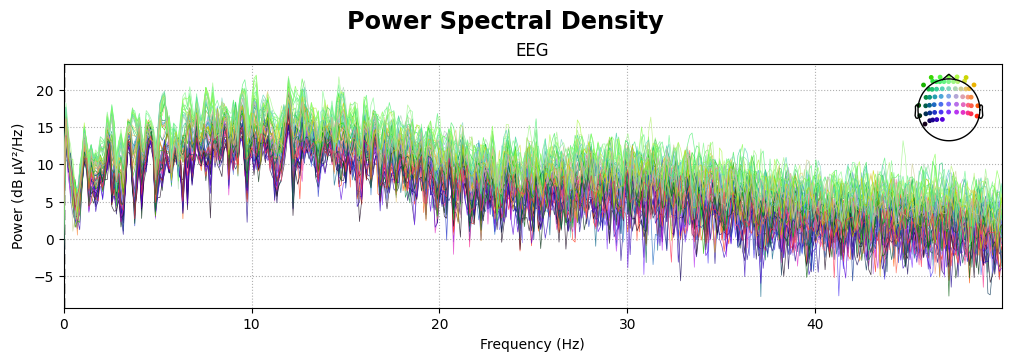

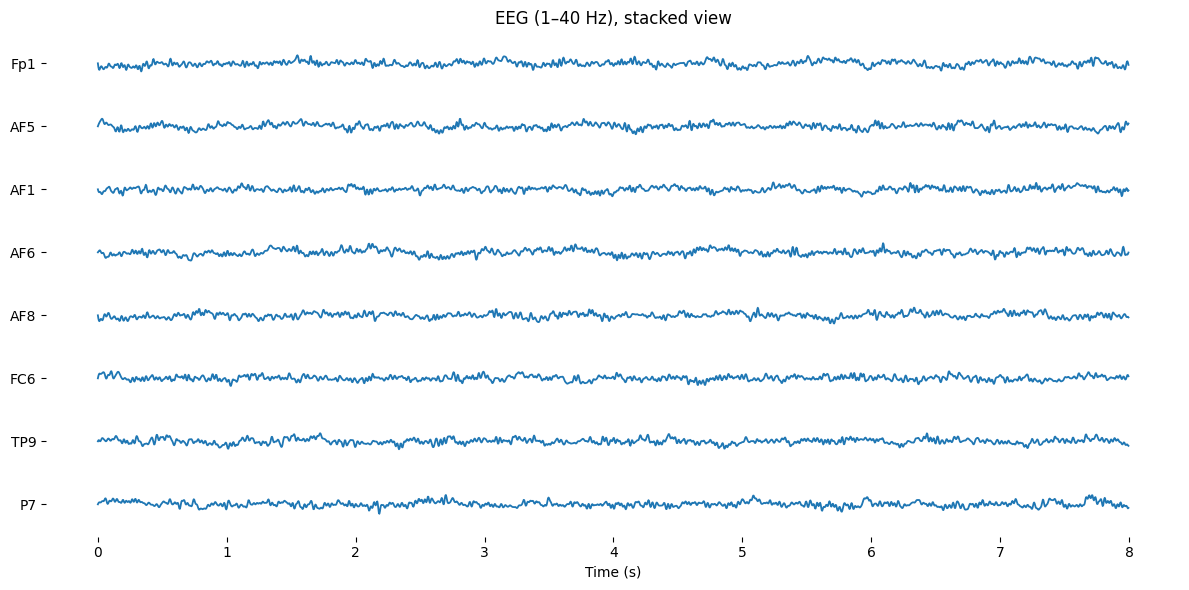

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# ===== 설정 =====
N_CH = 10
T0 = 0.0          # 시작 시간 (s)
DURATION = 8.0    # 구간 길이 (s)
BAND = (1., 40.)  # 필터
SPACING = 50e-6   # 채널 간 간격 (50 µV)
COLOR = "#1f77b4" # 발표용 블루

# ===== 채널 선택 =====
# picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=False)[:N_CH]
picks = [0, 5, 7, 11, 12, 33, 47, 59]
ch_names = [raw.ch_names[i] for i in picks]

# ===== 필터 =====
raw_viz = raw.copy().filter(*BAND, fir_design="firwin", verbose=False)

# ===== 데이터 추출 =====
sfreq = raw_viz.info["sfreq"]
start = int(T0 * sfreq)
stop  = int((T0 + DURATION) * sfreq)

data = raw_viz.get_data(picks=picks, start=start, stop=stop)
times = np.arange(data.shape[1]) / sfreq + T0

# ===== stacked plot =====
offsets = np.arange(len(picks))[::-1] * SPACING

plt.figure(figsize=(12, 6))
for i in range(len(picks)):
    plt.plot(times, data[i] + offsets[i], color=COLOR, linewidth=1.3)

plt.yticks(offsets, ch_names)
plt.xlabel("Time (s)")
plt.title("EEG (1–40 Hz), stacked view")
plt.box(False)
plt.tight_layout()

plt.savefig("eeg_stacked_clean.png", dpi=300, bbox_inches="tight")
plt.show()



In [26]:
print(np.median(np.abs(data)), np.max(np.abs(data)))

1.3334757624306345e-06 7.530659118240416e-06


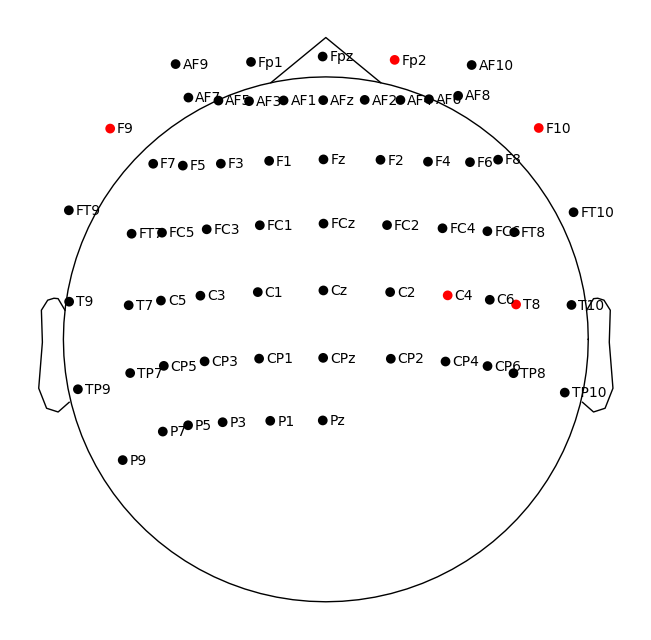

In [7]:
fig = raw.plot_sensors(show_names=True)

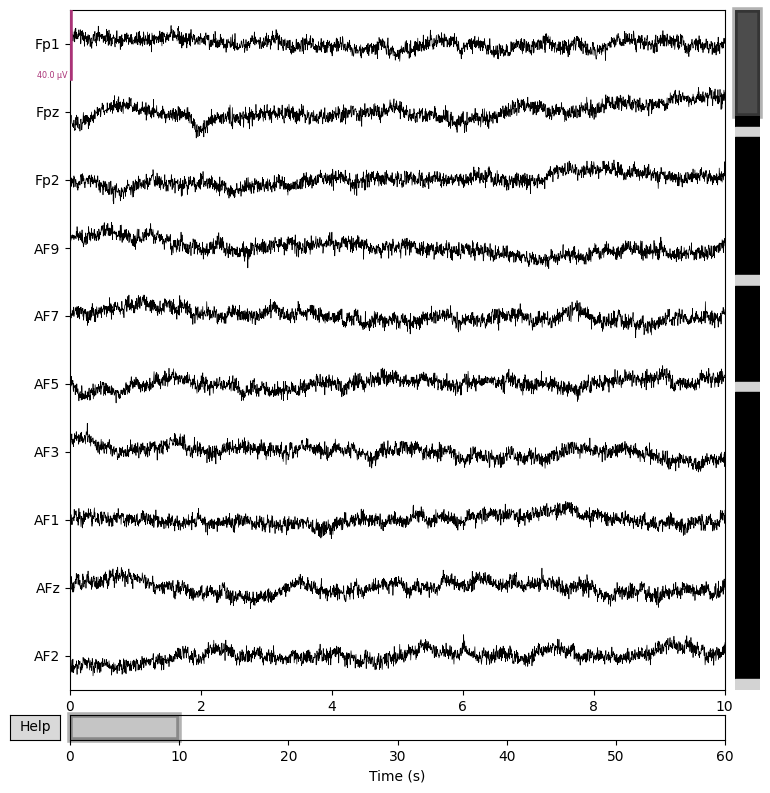

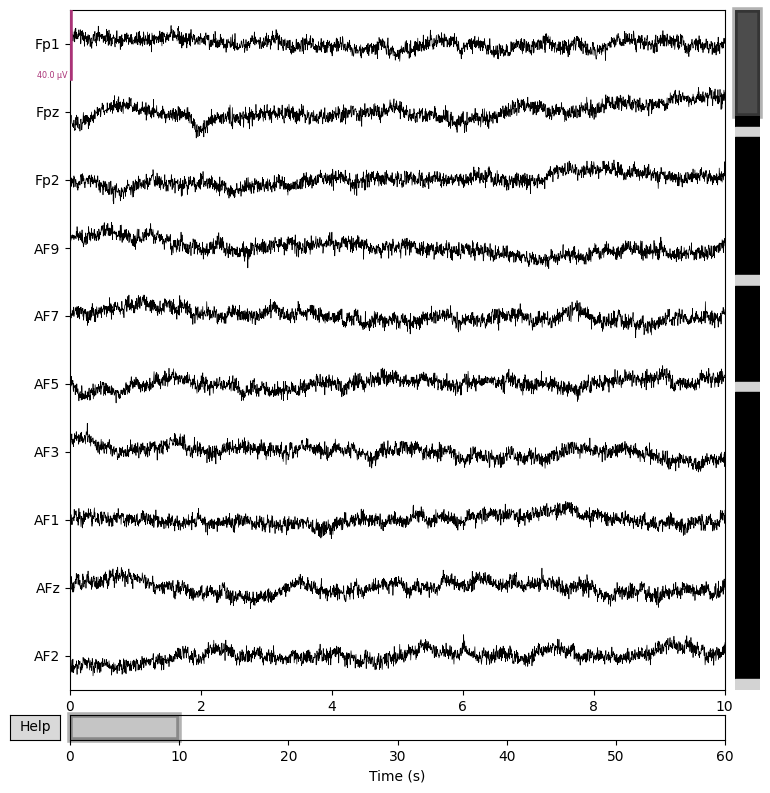

In [28]:
raw.plot(
    duration=10,       # 한 화면에 몇 초
    n_channels=min(10, 64),
    remove_dc=True,
    block=False
)

In [46]:
data = raw.get_data()  # shape: (n_ch, n_times)

# robust stats
median = np.median(data, axis=1)
mad = stats.median_abs_deviation(data, axis=1, scale="normal")  # robust std 추정
std = data.std(axis=1)
ptp = data.ptp(axis=1)  # peak-to-peak

# NaN/Inf 체크
nan_count = np.isnan(data).sum()
inf_count = np.isinf(data).sum()
print("\n=== NaN/Inf ===")
print("NaN:", nan_count, "Inf:", inf_count)

print("\n=== Per-channel summary (first 10) ===")
for i in range(min(10, n_ch)):
    print(f"{ch_names[i]:<15} median={median[i]: .3e}, MAD~std={mad[i]: .3e}, std={std[i]: .3e}, ptp={ptp[i]: .3e}")


=== NaN/Inf ===
NaN: 0 Inf: 0

=== Per-channel summary (first 10) ===
Fp1             median=-2.487e-02, MAD~std= 7.824e+00, std= 8.556e+00, ptp= 6.420e+01
Fpz             median=-2.920e-02, MAD~std= 7.928e+00, std= 8.650e+00, ptp= 6.476e+01
Fp2             median=-1.018e-02, MAD~std= 8.118e+00, std= 8.872e+00, ptp= 6.609e+01
AF9             median= 8.070e-03, MAD~std= 8.322e+00, std= 9.108e+00, ptp= 6.751e+01
AF7             median= 3.773e-02, MAD~std= 8.346e+00, std= 9.130e+00, ptp= 6.777e+01
AF5             median= 6.774e-02, MAD~std= 8.134e+00, std= 8.893e+00, ptp= 6.653e+01
AF3             median= 7.375e-02, MAD~std= 7.825e+00, std= 8.558e+00, ptp= 6.458e+01
AF1             median= 4.129e-02, MAD~std= 7.570e+00, std= 8.277e+00, ptp= 6.281e+01
AFz             median=-1.215e-03, MAD~std= 7.401e+00, std= 8.120e+00, ptp= 6.172e+01
AF2             median=-8.903e-02, MAD~std= 7.385e+00, std= 8.100e+00, ptp= 6.149e+01
